# Denoising Autoencoder
This notebook demonstrates a convolutional autoencoder trained to remove synthetic Gaussian noise from images. We evaluate the model using PSNR, SSIM, and MAE metrics.


In [ ]:
!rm -r "/content/drive/MyDrive/data/resizedImage256WithNoise"

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from PIL import Image
import random
import glob
import os
import cv2
import numpy as np
import pandas as pd
from google.colab import drive

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, LeakyReLU, Input,BatchNormalization,Dropout,Dense, Input,MaxPooling2D,Conv2D,Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential ,load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam, RMSprop, SGD


## Load Images and Add Noise
- Load original images
- Add Gaussian noise at different SNR levels
- Save noisy versions


In [ ]:
drive.mount('/content/drive')

def add_gaussian_noise(image, mean=0, std=10):
    image = np.array(image).astype(np.float32)
    noise = np.random.normal(mean, std, image.shape).astype(np.float32)

    noisy_image = image + noise
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)

    return Image.fromarray(noisy_image)

for filename in os.listdir("/content/drive/MyDrive/data/resizedImage256"):

    img_path = os.path.join("/content/drive/MyDrive/data/resizedImage256/", filename)
    with Image.open(img_path) as img:
      image = img.convert('RGB')
      clear_output(wait=True)
      print(filename)
      image.save(f"/content/drive/MyDrive/data/resizedImage256WithNoise/no_noise_{filename}")
      for i in range(2,8):
        image = add_gaussian_noise(image,i*10)
        image.save(f"/content/drive/MyDrive/data/resizedImage256WithNoise/{i*10}noise_{filename}")


sad216.jpg


## Define the Autoencoder
- Fully convolutional encoder–decoder structure
- Latent space dimension: 128
- Loss: Mean Squared Error (MSE)

In [ ]:
from tensorflow.keras.layers import Dense,Reshape, Input,MaxPooling2D,Conv2D,Flatten,Activation,Dropout,UpSampling2D,Conv2DTranspose


model = Sequential([
    #Encoder
    Conv2D(filters=32, kernel_size=(3, 3), input_shape=(256, 256, 3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2, 2), padding='same'),

    Conv2D(filters=64,kernel_size=(3, 3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2, 2), padding='same'),

    Conv2D(filters=128,kernel_size=(3, 3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    #latent space
    Flatten(),
    Dense(128),
    Dense(32*32*128, activation='relu'),
    Reshape((32, 32, 128)),

    # Decoder
    Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation='relu'),
    Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu'),
    Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu'),

    Conv2D(3, (3, 3), activation='sigmoid', padding='same')
])

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    16,777,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 131072)         │    16,908,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 64, 64, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 128, 128, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 256, 256, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,019,587 (129.77 MB)

 Trainable params: 34,019,587 (129.77 MB)

 Non-trainable params: 0 (0.00 B)

In [2]:
drive.mount('/content/drive')

model = load_model('/content/drive/My Drive/models/auto-encoder.keras')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Train the Autoencoder
- Training with train/validation split
- Batch size: 28
- Number of epochs: 30

In [3]:
from IPython.display import clear_output
from google.colab import drive
drive.mount('/content/drive')

data_dir = "/content/drive/MyDrive/data/resizedImage256WithNoise"
all_images = os.listdir(data_dir)

noisy_paths = []
clean_paths = []


for i in range(6,len(all_images)):

    clear_output(wait=True)
    print(f'{i}/{len(all_images)}')
    currentImagePath = all_images[i]
    if 'no_noise' in currentImagePath:
      real_image = os.path.join(data_dir, currentImagePath)
      noisy_image = os.path.join(data_dir, currentImagePath)
    else:
      noisy_image = os.path.join(data_dir, currentImagePath)

    noisy_paths.append(noisy_image)
    clean_paths.append(real_image)

train_noisy, test_noisy, train_clean, test_clean = train_test_split(
    noisy_paths, clean_paths, test_size=0.2, random_state=42
)

AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = (256, 256)
BATCH = 28

def decode_and_resize(noisy_path, clean_path):
    noisy_img = tf.io.read_file(noisy_path)
    noisy_img = tf.image.decode_image(noisy_img, channels=3, expand_animations=False)
    noisy_img = tf.image.resize(noisy_img, IMG_SIZE)
    noisy_img = tf.cast(noisy_img, tf.float32) / 255.0

    clean_img = tf.io.read_file(clean_path)
    clean_img = tf.image.decode_image(clean_img, channels=3, expand_animations=False)
    clean_img = tf.image.resize(clean_img, IMG_SIZE)
    clean_img = tf.cast(clean_img, tf.float32) / 255.0

    return noisy_img, clean_img

train_ds = tf.data.Dataset.from_tensor_slices((train_noisy, train_clean))
train_ds = train_ds.shuffle(buffer_size=len(train_noisy)) \
                   .map(decode_and_resize, num_parallel_calls=AUTOTUNE) \
                   .batch(BATCH).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((test_noisy, test_clean))
val_ds = val_ds.map(decode_and_resize, num_parallel_calls=AUTOTUNE) \
              .batch(BATCH).prefetch(AUTOTUNE)


13915/13916


In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30
)

In [5]:
model.save('/content/drive/MyDrive/models/auto-encoder2.keras')

In [ ]:
model = load_model('/content/drive/My Drive/models/auto-encoder.keras')

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
latent_input = Input(shape=(128,))
x = latent_input
for layer in model.layers[8:]:  # From Dense(131072) to end
    x = layer(x)
decoder = Model(inputs=latent_input, outputs=x, name="decoder")


## Latent Space Exploration
- Decode random vectors from latent space
- Generate new image

In [6]:
import matplotlib.pyplot as plt

def plot_test_image(images):
  rows = 2
  cols = 4

  fig, axs = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))  # Bigger size per image

  for i in range(rows):
      for j in range(cols):
          idx = i * cols + j
          axs[i, j].imshow(images[idx])
          axs[i, j].axis('off')

  plt.tight_layout()
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


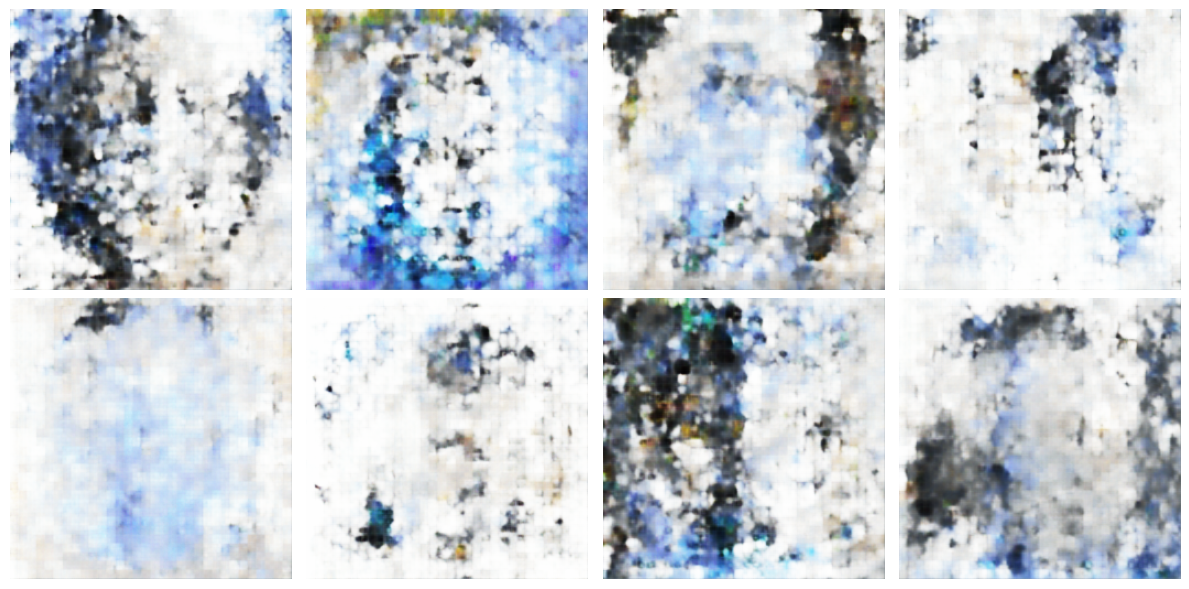

In [8]:
import numpy as np

latent_vectors = np.random.randn(8, 128)
decoded_images = decoder.predict(latent_vectors)


decoded_images = decoded_images.reshape(8, 256, 256, 3)
plot_test_image(decoded_images)



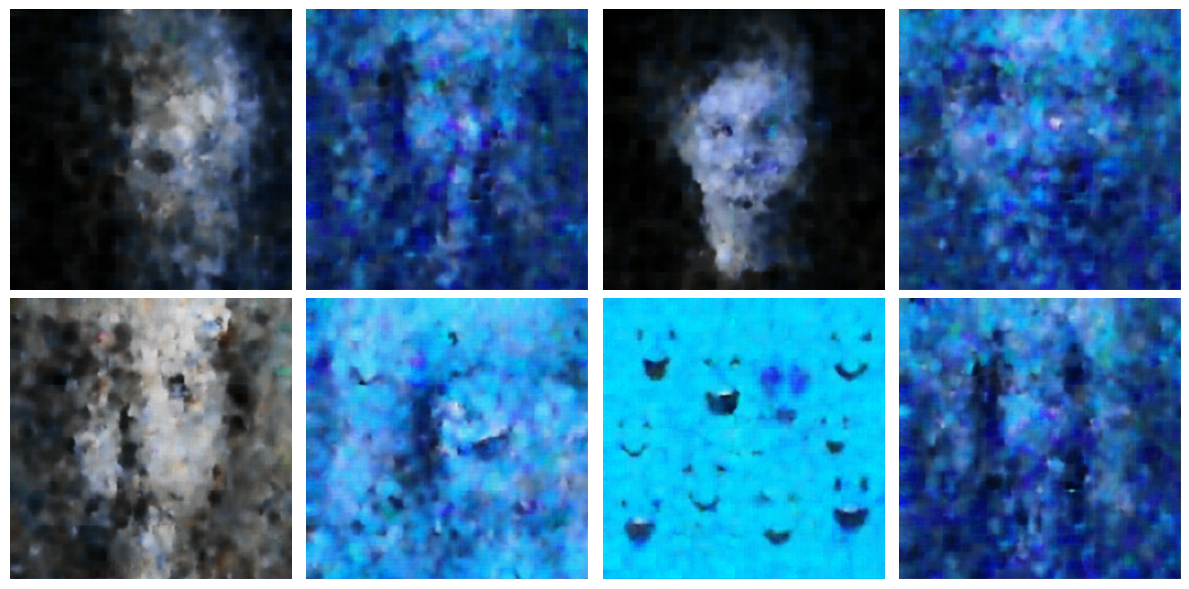

In [11]:
for i in range(0,60):
  decoded_images = model.predict(decoded_images,verbose=0)

  decoded_images = decoded_images.reshape(8, 256, 256, 3)
plot_test_image(decoded_images)

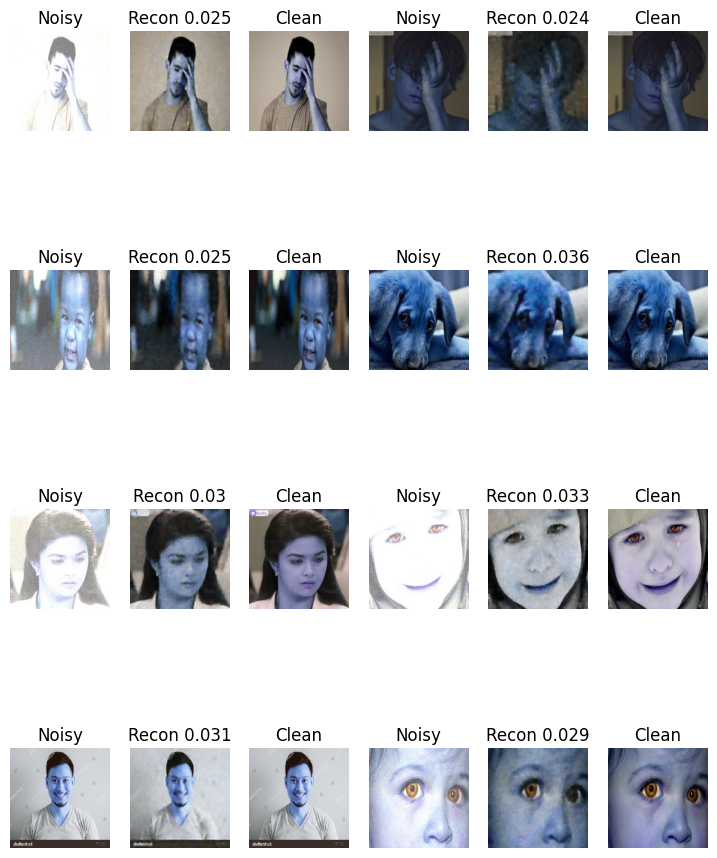

In [27]:
import matplotlib.pyplot as plt
import numpy as np

filtered_noisy = [n for n in train_noisy if "60noise" not in n and"20noise" not in n and "70noise" not in n and "30noise" not in n]
filtered_clean = [c for n, c in zip(train_noisy, train_clean) if "60noise" not in n and "20noise" not in n and "70noise" not in n and "30noise" not in n]

size  = 8
idxs = np.random.choice(len(filtered_noisy), size=size, replace=False)

plt.figure(figsize=(9, 15))
for i, idx in enumerate(idxs):
    noisy = cv2.imread(filtered_noisy[idx])
    clean = cv2.imread(filtered_clean[idx])

    noisy = cv2.cvtColor(noisy, cv2.COLOR_BGR2RGB) / 255.0
    clean = cv2.cvtColor(clean, cv2.COLOR_BGR2RGB) / 255.0

    pred = model.predict(np.expand_dims(noisy, axis=0), verbose=0)[0]
    mse = np.mean(abs(clean - pred))
    plt.subplot(5, 6, i*3+1)
    plt.imshow(noisy)
    plt.title("Noisy")
    plt.axis("off")

    plt.subplot(5, 6, i*3+2)
    plt.imshow(pred)
    plt.title(f"Recon {mse:.2}")
    plt.axis("off")


    plt.subplot(5, 6, i*3+3)
    plt.imshow(clean)
    plt.title("Clean")
    plt.axis("off")


plt.show()


### reconstructing from pure noise images

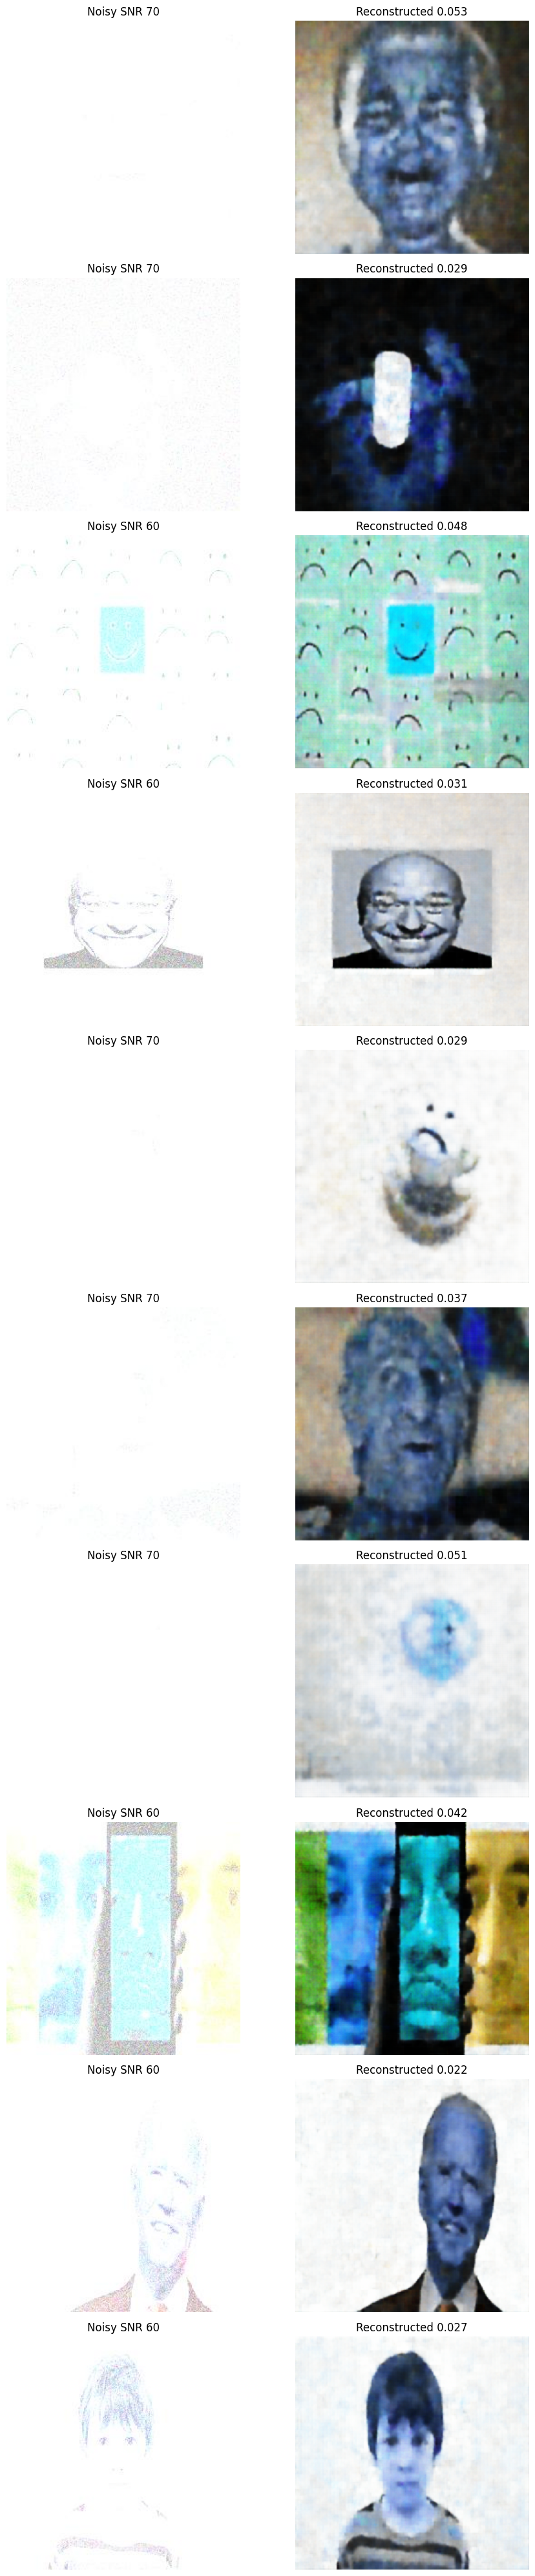

In [24]:
filtered_noisy = [n for n in train_noisy if "60noise" in n or "70noise" in n]
filtered_clean = [c for n, c in zip(train_noisy, train_clean)  if "60noise" in n or "70noise" in n]

size = 10
idxs = np.random.choice(len(filtered_noisy), size=size, replace=False)

plt.figure(figsize=(10, 4*size))

for i, idx in enumerate(idxs):
    noisy = cv2.imread(filtered_noisy[idx])
    noisy = cv2.cvtColor(noisy, cv2.COLOR_BGR2RGB) / 255.0
    clean = cv2.imread(filtered_clean[idx])
    clean = cv2.cvtColor(clean, cv2.COLOR_BGR2RGB) / 255.0

    pred = model.predict(np.expand_dims(noisy, axis=0), verbose=0)[0]
    if "60noise" in filtered_noisy[idx]:
      snr = "SNR 60"
    else:
      snr = "SNR 70"

    mse = np.mean(abs(clean - pred))

    plt.subplot(size, 2, i*2+1)
    plt.imshow(noisy)
    plt.title("Noisy "+snr)
    plt.axis("off")

    plt.subplot(size, 2, i*2+2)
    plt.imshow(pred)
    plt.title(f"Reconstructed {mse:.2}")
    plt.axis("off")

plt.tight_layout()
plt.show()


## Evaluate Autoencoder Performance
- Metrics: PSNR, SSIM, MAE
- Histogram distributions for each metric





### 1. PSNR (Peak Signal-to-Noise Ratio)

The PSNR measures the pixel-level similarity between the original image and the reconstructed image. Higher PSNR indicates better reconstruction.

$
\text{PSNR} = 20 \cdot \log_{10}\left(\frac{\text{MAX}_I}{\sqrt{\text{MSE}}}\right)
$

Where:

- $\text{MAX}_I$= maximum possible pixel value of the image
- $\text{MSE}$ = Mean squared error pixel wise

Higher PSNR → better reconstruction.

30 dB → very good quality

25–30 dB → acceptable quality

25 dB → visible distortions

---

### 2. SSIM (Structural Similarity Index Measure)

The SSIM measures structural similarity between images, considering luminance, contrast, and structure. It is more perceptually aligned than PSNR.

**Range:**

1.0 = identical images

0.9+ = excellent similarity

0.7–0.9 = decent but some loss

0.7 = noticeable distortions

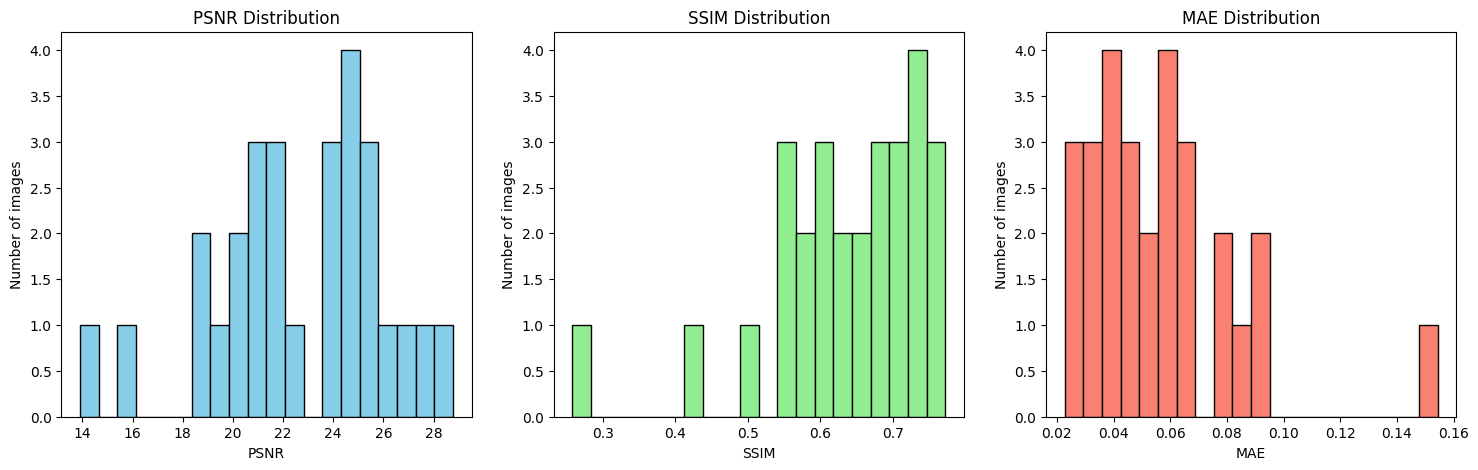

Average PSNR: 22.691608
Average SSIM: 0.63511413
Average MAE : 0.056601565


(np.float32(22.691608), np.float32(0.63511413), np.float32(0.056601565))

In [7]:
import numpy as np
import tensorflow as tf

def evaluate_autoencoder(model, noisy_batch, clean_batch):
    preds = model.predict(noisy_batch, verbose=0)

    psnr_scores, ssim_scores, mae_scores = [], [], []

    for i in range(len(clean_batch)):
        psnr = tf.image.psnr(clean_batch[i], preds[i], max_val=1.0).numpy()
        ssim = tf.image.ssim(clean_batch[i], preds[i], max_val=1.0).numpy()
        mae  = tf.reduce_mean(tf.abs(clean_batch[i] - preds[i])).numpy()  # Mean Absolute Error

        psnr_scores.append(psnr)
        ssim_scores.append(ssim)
        mae_scores.append(mae)


    plt.figure(figsize=(18,5))
    plt.subplot(1,3,1)

    plt.hist(psnr_scores, bins=20, color='skyblue', edgecolor='black')
    plt.title("PSNR Distribution")
    plt.xlabel("PSNR")
    plt.ylabel("Number of images")
    plt.subplot(1,3,2)

    plt.hist(ssim_scores, bins=20, color='lightgreen', edgecolor='black')
    plt.title("SSIM Distribution")
    plt.xlabel("SSIM")
    plt.ylabel("Number of images")
    plt.subplot(1,3,3)

    plt.hist(mae_scores, bins=20, color='salmon', edgecolor='black')
    plt.title("MAE Distribution")
    plt.xlabel("MAE")
    plt.ylabel("Number of images")

    plt.show()

    print("Average PSNR:", np.mean(psnr_scores))
    print("Average SSIM:", np.mean(ssim_scores))
    print("Average MAE :", np.mean(mae_scores))
    return np.mean(psnr_scores), np.mean(ssim_scores), np.mean(mae_scores)


noisy_batch, clean_batch = next(iter(val_ds))
evaluate_autoencoder(model, noisy_batch, clean_batch)
